In [1]:
import numpy as np

import math


import matplotlib.pyplot as plt

from helpers import *
from algorithms import *
from data_simulation import *
from get_data import *
import time
import csv


shape of input training and validation data is: (200, 15) (200, 15)
shape of output training and validation data is: (200,) (200,)


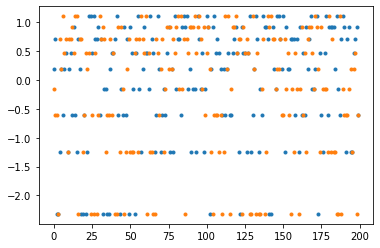

In [2]:
dataset = 'propulsion'
X_train, Y_train, X_val, Y_val = get_dataset_SALSA(dataset)
# plt.plot(X_train,'.')
# plt.plot(X_val,'.')
plt.plot(Y_train,'.')
plt.plot(Y_val,'.')

In [3]:
np.mean(Y_train)

6.999999999912631e-07

In [4]:
# np.random.seed(0)
num_data_train = X_train.shape[0] # number of data points for training data set
num_data_val = X_val.shape[0] # number of data points for validation data set
num_data_tot = num_data_train + num_data_val
N = 15*num_data_train # number of features

print('number of features is',N)
'''parameters to be changed everytime'''
d = X_train.shape[1] # input dimension for target function; 
q = 2


num_sets = 10 #number of to datasets
act = 'sin'
Dict_type = 'SRF'

number of features is 3000


In [5]:
mu = 0.100 #1/np.sqrt(N) #0.1 makes no diff
lam = 1e-12
s = int(N/10) #------too much sparsity can make the errors fluctuate
print('sparsity level:',s)
e = 1e-05
iter_htp = 50


sparsity level: 300


In [6]:
mse_full = np.zeros(num_sets)
Rmse_full = np.zeros(num_sets)
relVal_error_full = np.zeros(num_sets)
sparsity_full = np.zeros(num_sets)
LossRegVal = np.zeros((num_sets,2))
task = 'func'
runtime = np.zeros(num_sets)
for i in range(num_sets):

#     X_train, Y_train, X_val, Y_val = get_dataset(dataset,num_data_train,num_data_val)
    
    Y_train_noisy = Y_train 
    Y_val_noisy = Y_val 
    
    start_time = time.clock()
    Omega,bias = generate_omega_bias(rows = N,columns = d,weight = 1,par1 = -1,par2 = 1,
                                       distribution = 'uniform',bool_bias = True,sparsity = q)
    
    A_train = dictionary_SRF(X_train,Omega,bias,activation = act,dictType = Dict_type)
    A_val = dictionary_SRF(X_val,Omega,bias,activation = act,dictType = Dict_type)
    
    scale_A = np.linalg.norm(A_train, axis = 0) 
#     scale_A = np.linalg.norm(A_train) 
    A_train /= scale_A 
    A_val /= scale_A
    
          
    '''Run test using Hard Thresholding Pursuit'''
    c0_htp = np.zeros(A_train.shape[1])
    C_htp,error_htp,tot_iter_htp,sim = hard_thresh_pur_tik(A_train,Y_train_noisy,c0_htp,s,iter_htp,e,mu,lam,task)
    print(time.clock() - start_time, "seconds")
    runtime[i] = time.clock() - start_time
    
#     lasso_owl = OwlRegressor(weights=(alpha, beta))
#     lasso_owl.fit(A_train, Y_train.reshape(-1))

#     c_lasso_owl = lasso_owl.coef_
    
    '''Recover using the coefficients'''
    ytrain_rec_htp = np.matmul(A_train,C_htp[:,tot_iter_htp-1])
    yval_rec_htp = np.matmul(A_val,C_htp[:,tot_iter_htp-1])
    
    nnz_htp = sparsity(C_htp)
    error_train_htp = rel_error(A_train,C_htp[:,tot_iter_htp-1],Y_train,task) 
    error_val_htp = rel_error(A_val,C_htp[:,tot_iter_htp-1],Y_val,task)
    mseVal = np.linalg.norm(yval_rec_htp.flatten() - Y_val.flatten())**2/num_data_val
    RMSEVal = np.sqrt(mseVal)
    lossTrain = np.linalg.norm(ytrain_rec_htp.flatten() - Y_train)**2
    lossVal = np.linalg.norm(yval_rec_htp.flatten() - Y_val)**2
    regVal = lam*np.linalg.norm(C_htp[:,tot_iter_htp-1])**2
    
    mse_full[i] = mseVal
    Rmse_full[i] = RMSEVal
    relVal_error_full[i] = error_val_htp
    sparsity_full[i] =  nnz_htp
    LossRegVal[i,0] = lossVal
    LossRegVal[i,1] = regVal
    if i%1==0:
        print('the rmse is',RMSEVal,'at',i,'iter',mseVal,'data fitting:',lossTrain,'reg term:', regVal)
#     if mseVal<=0.26:
#         break


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  from ipykernel import kernelapp as app
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


2.5840359999999998 seconds
the rmse is 0.010544535118743092 at 0 iter 0.0001111872208704064 data fitting: 7.885256303570478e-05 reg term: 5.323847197485299e-06
3.0542029999999993 seconds
the rmse is 0.005589176378267173 at 1 iter 3.1238892587379756e-05 data fitting: 3.6564523959365645e-05 reg term: 6.54472893879102e-06
2.6653010000000004 seconds
the rmse is 0.005629665326553526 at 2 iter 3.169313168899902e-05 data fitting: 0.002192440157579059 reg term: 3.30182005007259e-06
2.841510999999999 seconds
the rmse is 0.006879346857540335 at 3 iter 4.732541318635008e-05 data fitting: 0.00042668471510260434 reg term: 3.9967202115080384e-06
2.6595039999999983 seconds
the rmse is 0.004606453069862809 at 4 iter 2.12194098848485e-05 data fitting: 0.0009551606420271571 reg term: 4.761569702772592e-06
2.778796999999999 seconds
the rmse is 0.007190971446931882 at 5 iter 5.17100703505896e-05 data fitting: 0.0018445469797253634 reg term: 4.218464222226689e-06
2.3759300000000003 seconds
the rmse is 0.00

In [7]:
mse = np.mean(mse_full)
rmse = np.mean(Rmse_full)
Val_error = np.mean(relVal_error_full)

sparsity = np.mean(sparsity_full)
loss = np.mean(LossRegVal[:,0])
reg = np.mean(LossRegVal[:,1])
print('\nMean MSE:',mse,'\nMean rel val error:',Val_error,
     '\nSparsity level:',sparsity,'\nLoss value is',loss,'\nRegularization value is',reg)
print('avg time taken:',np.mean(runtime))
print('\nMean MSE:',mse,', #features:',N,', sparsity:',s,', lam:',lam,', q:',q, ', final sparsity:',sparsity)


Mean MSE: 4.8659556008421436e-05 
Mean rel val error: 0.005955644407718419 
Sparsity level: 6.0464 
Loss value is 0.009731911201684287 
Regularization value is 6.513220360994624e-06
avg time taken: 2.7769787999999997

Mean MSE: 4.8659556008421436e-05 , #features: 3000 , sparsity: 300 , lam: 1e-12 , q: 2 , final sparsity: 6.0464


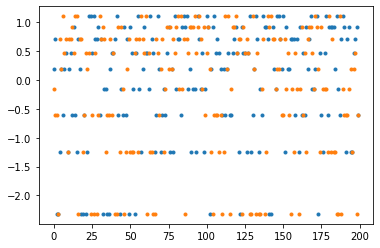

In [8]:
# #music
# #0.6251
# 0.6134; lam = 2.5; q=3; N=10k, s=666

#insulin
#1.0146
#1.0194416824316146 lam = 2.5, q=3, N= 10*num_train, s = N/15 [ 1.0146180452269786(2.25),  1.016736965026263 (q=2,lam = 2.75)]
#1.0156010117592444 lam = 2.5, q=2, N= 10*num_train, s = N/15

#telemonitor
# 0.0285; 0.0347
# 0.0364514 @ lam = 0.1, q = 5, N = 15*num_train, s = N/15
#Mean MSE: 0.0377919849688412 , #features: 20000 , sparsity: 800 , lam: 0.1 , q: 5
# Mean MSE: 0.03700047825374643 , #features: 15000 , sparsity: 937 , lam: 0.1 , q: 5

#speech
#0.0224
plt.plot(Y_train,'.')
plt.plot(Y_val,'.')

(3000,)


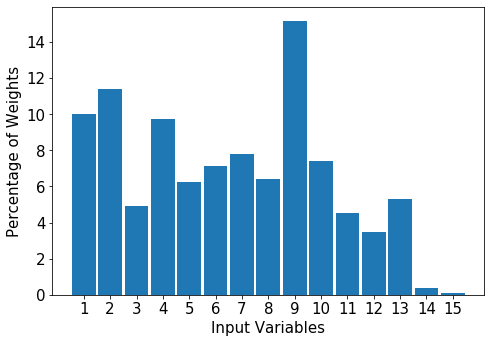

In [9]:
plot_hist_weights(C_htp[:,tot_iter_htp-1],s,d,Omega,Dict_type)

In [10]:
# import numpy as np

# import math


# import matplotlib.pyplot as plt

# from helpers import *
# from algorithms import *
# from data_simulation import *
# from get_data import *
# import time
# import csv



# tmp = csv.reader(open("DataFolder/superconduct/train.csv"), delimiter = ",")
# x = list(tmp)
# data = np.array(x[1:]).astype("float")
# print(data.shape)
# X = data[:,0:81]
# Y = data[:,81]
# X_train, Y_train, X_val, Y_val = make_data_sets(X,Y,10663,10600)